In [1]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 56kB/s 


In [2]:
! pip install keras

In [3]:
! pip install pandas

In [5]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


In [97]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [60]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score
import os
import cv2

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
X = []
y = []
IMG_SIZE = 224
DIR = "/content/drive/My Drive/Colab Notebooks/Tamoto_Leaf/"
folders1 = os.listdir(DIR)
folders1

['Tomato_Healthy', 'Tomato_Diseased']

In [63]:

for i, file in enumerate(folders1):
    filename = os.path.join(DIR, file)
    print("Folder {} started".format(file))
    try:
        for img in os.listdir(filename):
            path = os.path.join(filename, img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            y.append(i)
    except:
        print("File {} not read".format(path))
        
    print("Folder {} done".format(file))
    print("The folder {} is labeled as {}".format(file, i))



Folder Tomato_Healthy started
Folder Tomato_Healthy done
The folder Tomato_Healthy is labeled as 0
Folder Tomato_Diseased started
Folder Tomato_Diseased done
The folder Tomato_Diseased is labeled as 1


In [64]:
len(X)

3718

[1154, 296, 2225, 1236, 897, 1692, 1057, 2486, 1900, 579]


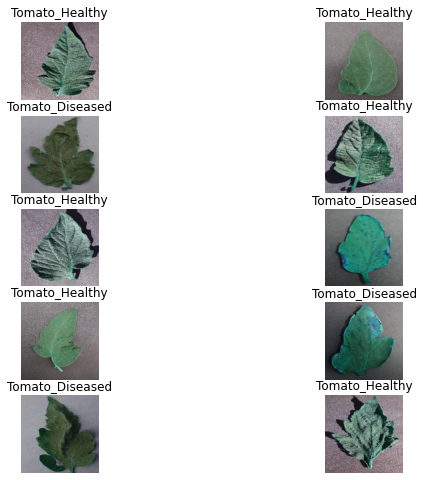

In [65]:
import random
from random import sample
plt.figure(figsize=(10,10))
random_indexes = sample(range(1, 3184), 10)
print(random_indexes)
for i, img_index in enumerate(random_indexes):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(6,2, i + 1)
  sp.set_title(folders1[y[img_index]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X[img_index])


In [66]:
X = np.array(X)
y = np.array(y)

print("X shape is {}".format(X.shape))
print("y shape is {}".format(y.shape))

X shape is (3718, 224, 224, 3)
y shape is (3718,)


In [67]:
from tensorflow.keras.utils import to_categorical

print("Before the categorical the shape of y is {}".format(y.shape))
y = to_categorical(y)
print("After the categorical the shape of y is {}".format(y.shape))

Before the categorical the shape of y is (3718,)
After the categorical the shape of y is (3718, 2)


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("There are {} training examples".format(X_train.shape[0]))
print("There are {} test examples".format(X_test.shape[0]))

There are 2788 training examples
There are 930 test examples


In [69]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


validation_datagen = ImageDataGenerator(
      rescale = 1./255)

In [70]:
training_set=training_datagen.flow(X_train,y_train)
test_set=validation_datagen.flow(X_test,y_test)

In [98]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3",
# Here we will be using imagenet weights\n"
IMAGE_SIZE=[224,224]
vgg= VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [99]:
# don't train existing weights\n",
for layer in vgg.layers:
    layer.trainable = False

In [100]:
folders = glob('/content/drive/My Drive/Colab Notebooks/Tamoto_Leaf/*')
len(folders)

2

In [101]:
x = Flatten()(vgg.output)

In [102]:

prediction=Dense(len(folders), activation='softmax')(x)

In [103]:
model = Model(inputs=vgg.input, outputs=prediction)

In [104]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [105]:

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [106]:
batch_size=32
r= model.fit_generator(training_set,epochs = 10, validation_data = test_set,verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
87/87 [==============================] - 47s 541ms/step - loss: 0.2975 - accuracy: 0.8872 - val_loss: 0.1439 - val_accuracy: 0.9516
Epoch 2/10
87/87 [==============================] - 46s 528ms/step - loss: 0.0457 - accuracy: 0.9906 - val_loss: 0.0411 - val_accuracy: 0.9871
Epoch 3/10
87/87 [==============================] - 46s 525ms/step - loss: 0.0235 - accuracy: 0.9985 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 4/10
87/87 [==============================] - 46s 530ms/step - loss: 0.0177 - accuracy: 0.9993 - val_loss: 0.0130 - val_accuracy: 0.9978
Epoch 5/10
87/87 [==============================] - 46s 526ms/step - loss: 0.0156 - accuracy: 0.9975 - val_loss: 0.0114 - val_accuracy: 0.9989
Epoch 6/10
87/87 [==============================] - 46s 524ms/step - loss: 0.0151 - accuracy: 0.9989 - val_loss: 0.0149 - val_accuracy: 0.9957
Epoch 7/10
87/87 [==============================] - 46s 525ms/step - loss: 0.0107 - accuracy: 0.9985 - val_loss: 0.0155 - val_accuracy: 0.9957

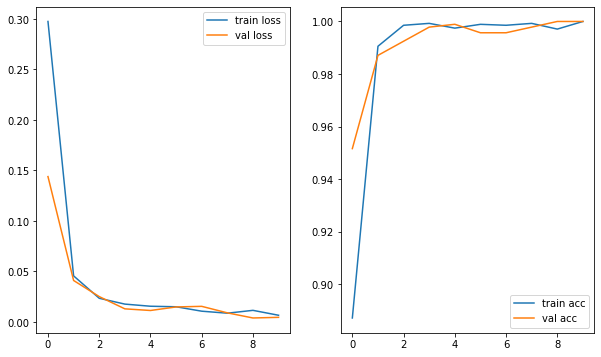

In [107]:
# plot the loss
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc')

In [108]:
k=r.history['val_accuracy']
print('The Validation Accuracy of VGG16 Model: ', np.array(k[-1]))

The Validation Accuracy of VGG16 Model:  1.0


In [109]:
# save it as a h5 file

from tensorflow.keras.models import load_model
model.save('tamoto_leaf_model_VGG16.h5')

In [110]:
y_pred = model.predict(X_test)
y_pred_digits = np.argmax(y_pred, axis=1)
y_pred_digits

y_pred_labels = np.unique(y_pred_digits, return_counts=True)
y_pred_labels


(array([0, 1]), array([728, 202]))

In [111]:
real_labels= np.argmax(y_test, axis=1)
real_labels
real_labels1 = np.unique(real_labels, return_counts=True)
real_labels1

(array([0, 1]), array([418, 512]))

In [112]:
from sklearn.metrics import confusion_matrix
c_m = confusion_matrix(real_labels, y_pred_digits)
c_m

array([[418,   0],
       [310, 202]])

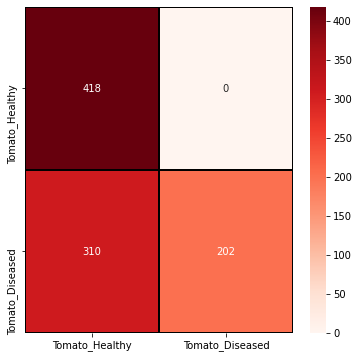

In [113]:

import seaborn as sns
plt.figure(figsize = (6,6))
sns.heatmap(c_m,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = folders1 , yticklabels = folders1)

In [114]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score
acc_score = accuracy_score(real_labels, y_pred_digits)
acc_score

0.6666666666666666

In [115]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(real_labels)):
    if(real_labels[i] == y_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==10):
        break
i=0
for i in range(len(real_labels)):
    if(real_labels[i] != y_pred_digits[i]):
        mis_class.append(i)


In [119]:
print(len(prop_class))
print(len(mis_class))

10
310


[5, 0, 2, 4, 1, 9, 6, 3, 7, 8]


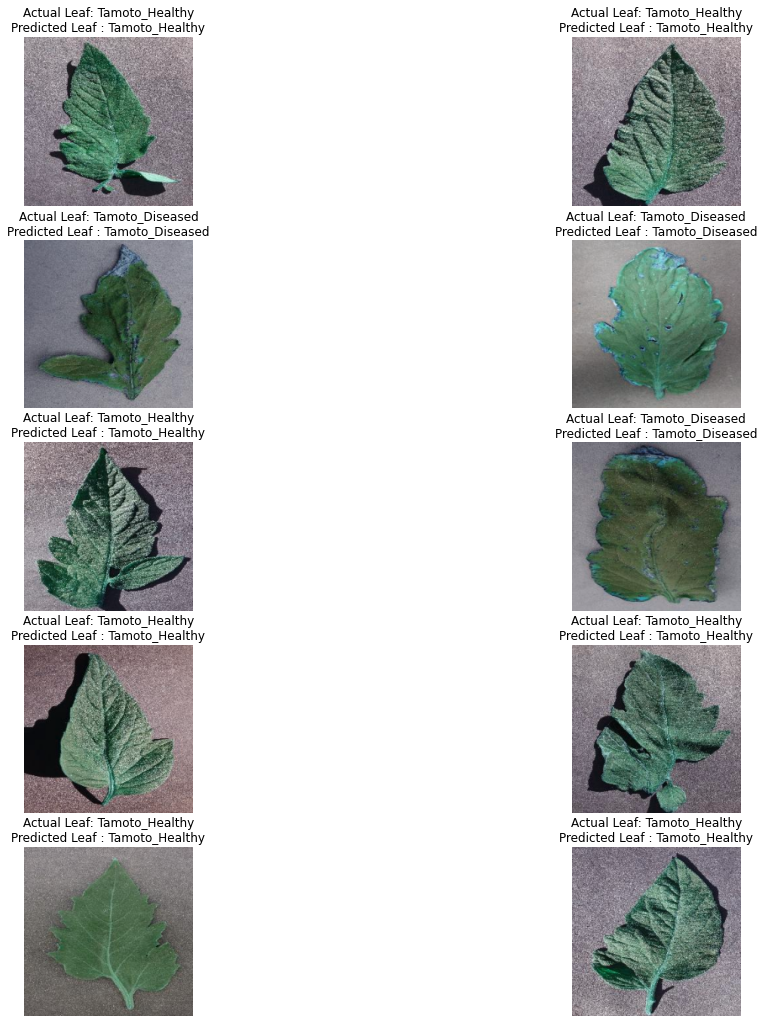

In [120]:
labels_names={0:'Tamoto_Healthy', 
        1:'Tamoto_Diseased',
        }
#fig.set_size_inches(8,8)
import random
from random import sample
plt.figure(figsize=(18,18))
random_indexes = sample(range(0, 10), 10)
print(random_indexes)
for i, img_index in enumerate(random_indexes):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 2, i + 1)
  sp.set_title('Actual Leaf: '+ labels_names[real_labels[prop_class[img_index]]]+ '\n' + 'Predicted Leaf : ' + labels_names[y_pred_digits[prop_class[img_index]]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X_test[prop_class[img_index]])

[6, 1, 8, 0, 5, 4, 9, 2, 3, 7]


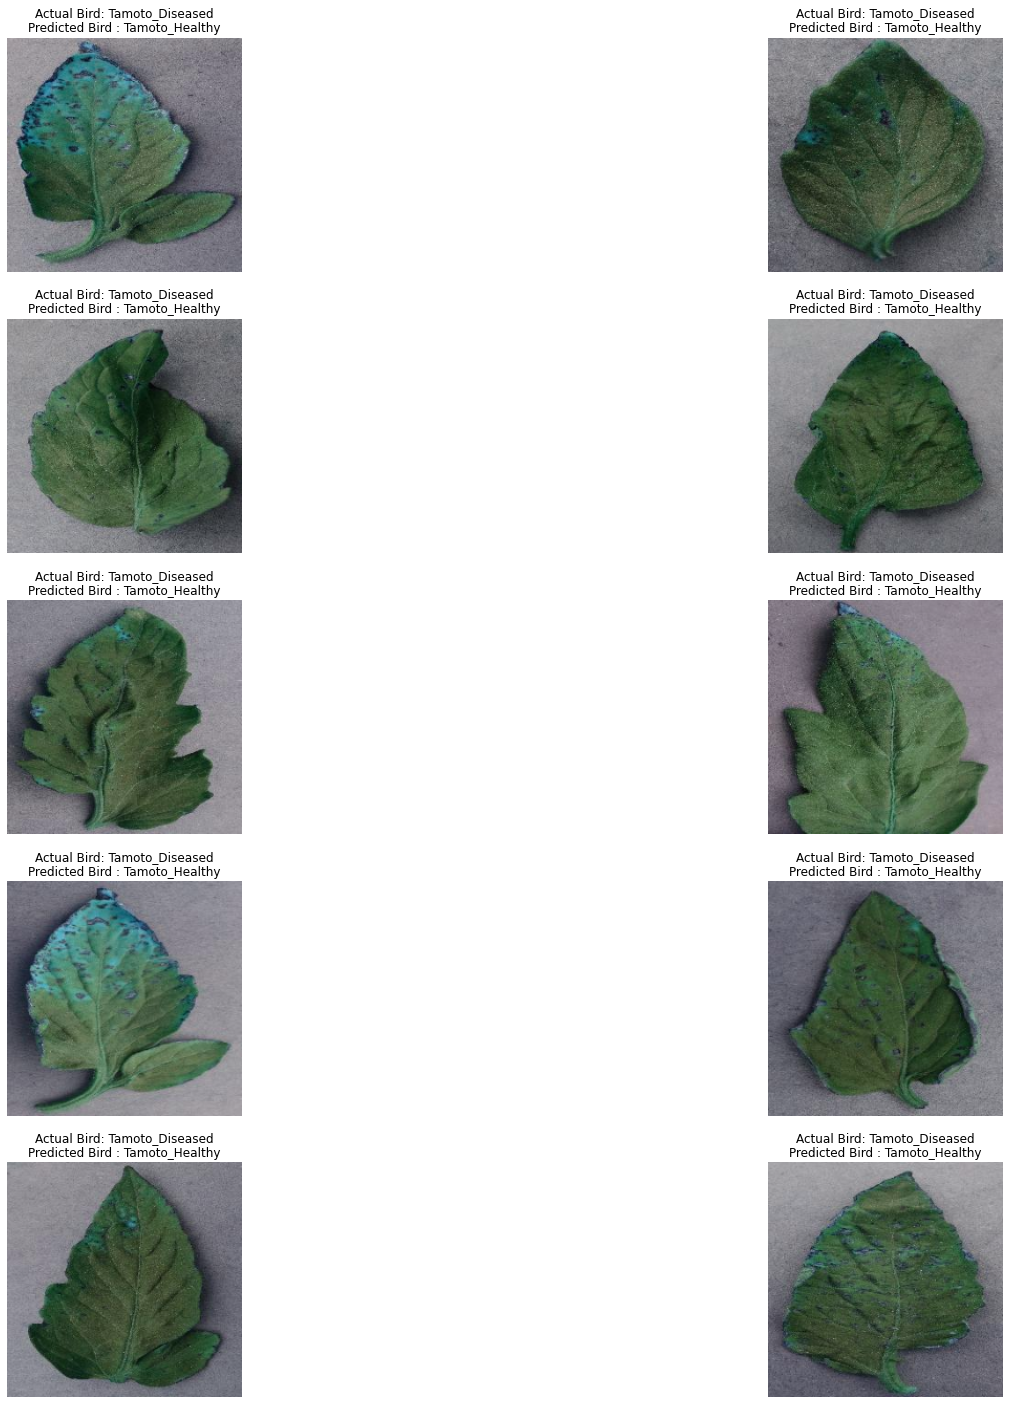

In [121]:
labels_names={0:'Tamoto_Healthy', 
        1:'Tamoto_Diseased',
        }
import random
from random import sample

random_indexes = sample(range(0, 10), 10)
print(random_indexes)
plt.figure(figsize=(25,25))
for i, img_index in enumerate(random_indexes):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 2, i + 1)
  sp.set_title('Actual Bird: '+ labels_names[real_labels[mis_class[img_index]]]+ '\n' + 'Predicted Bird : ' + labels_names[y_pred_digits[mis_class[img_index]]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X_test[mis_class[img_index]])

In [ ]:
# Evaluate The Model with Different Images

In [122]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [123]:
model=load_model('tamoto_leaf_model_VGG16.h5')

In [124]:
img=image.load_img('/content/drive/My Drive/Colab Notebooks/Validate_Plant Leaf/Tomoto_Diseased.JPG',target_size=(224,224))

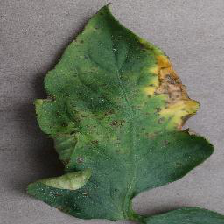

In [125]:
img


In [126]:
y=image.img_to_array(img)
y=np.expand_dims(y,axis=0)
imgy=preprocess_input(y)
imgy=imgy/255

In [127]:
preds= model.predict(imgy)
preds

array([[1.4262117e-06, 9.9999857e-01]], dtype=float32)

In [128]:
a=np.argmax(preds, axis=1)
a

array([1])

In [129]:
if(a==0):
    print("Healthy")
else:
    print("Diseased")

Diseased
